# Understanding Autoencoders


## Dataset Source

- [Kaggle]()

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import math
import os
import random
import torch
from torch import nn
import numpy as np
from torchvision import transforms


device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"{device=}")


device='cuda'


In [6]:
!bash dataset_fetch.sh

+ '[' '!' -d dataset ']'
+ echo 'Dataset Directory already exist!'
Dataset Directory already exist!


In [8]:
# Helper Cell


def helper_imageGrid(image_paths, cols=4):
    img_count = len(image_paths)
    rows = math.ceil(img_count / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    irow, icol = 0, 0
    for path in image_paths:
        ax = axes[irow][icol]
        ax.imshow(Image.open(path))
        title = path.split("/")[-2]
        #ax.title(path)
        ax.axis("off")

        icol += 1
        if icol % cols == 0:
            icol = 0
            irow += 1

        
    
    return fig

import re


def helper_fetch_localmodel(mname="autoencoder", device=device):
    max_name = None
    max_num = 0
    for x in os.listdir():
        if a := re.match(f"{mname}_\\d+", x):
            name = a.group()
            num = int(name.split("_")[-1])
            max_num = num if max_num < num else max_num
    if max_num > 0:
        return max_num, torch.load(f"model/{mname}_{max_num}", map_location=torch.device(device))


In [3]:


image_paths = [ f"dataset/GAID/Soul/{x}" for x in os.listdir("dataset/GAID/Soul") ]


sizes = set()
for x in image_paths:
    img = Image.open(x)
    sizes.add(img.size)
    img.close()

print("Sizes of Images: ", sizes)
print("Count of Images: ", len(image_paths))




Sizes of Images:  {(300, 300)}
Count of Images:  1000


In [72]:

'''

100x100 --> 10x10 --> 10 --> 10x10 --> 100x100

'''



class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100**2, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 100**2),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))





def ReconstructionLoss(reproduced, original): 
    return torch.sum((original - reproduced)**2) / len(original)

print(f"{device} is Available!!")


cuda is Available!!


In [4]:


def todata(path):
    image = Image.open(path).convert("L").resize((100, 100))
    tensor = transforms.ToTensor()(image)
    tensor = nn.Flatten(0)(tensor)
    image.close()
    return tensor
    
def toimg(data):
    data = nn.Sigmoid()(data.view(100, 100)) * 255
    return np.uint8(data.detach().numpy())
    
auto = Autoencoder().to(device)


import matplotlib.pyplot as plt
import time
%matplotlib tk


fig = plt.figure()

raw_img = fig.add_axes([0, 0.5, 0.5 - 0.02, 0.5 - 0.02])
trans_img = fig.add_axes([0.5, 0.5, 0.5 - 0.02, 0.5 - 0.02])

loss_ax = fig.add_axes([0, 0, 1 - 0.02, 0.5 - 0.02])

raw_img.axis("off")
trans_img.axis("off")
loss_ax.axis("off")


fig.show()






epochs = 100
loss_ax.set_xlim(left=0, right=epochs)
optimizer = torch.optim.Adam(auto.parameters(),lr=0.001)
for epoch in range(epochs):

    sample_path = random.choice(image_paths)
    sample_data = todata(sample_path)
    sample_img = toimg(sample_data)

    raw_img.imshow(sample_img, cmap="ocean_r")
    timg = toimg(auto(sample_data.to(device)).to("cpu"))
    trans_img.imshow(timg, cmap="ocean_r")
    


    for path in image_paths:
        optimizer.zero_grad()
        sample = todata(path).to(device)
        op = auto(sample).to(device)
        loss = ReconstructionLoss(sample, op)
        loss.backward()

        optimizer.step()

    loss_ax.plot(epoch, loss.to("cpu").item(), "ro")
    fig.canvas.flush_events()
    fig.show()
    print(f"{epoch} done, {loss.to("cpu").item()}")


show_count = 10

fig, axes = plt.subplots(show_count, 2, figsize=(10, show_count * 5))

for i, path in enumerate(image_paths[:show_count]):
    data = todata(path).to(device)
    infer = auto(data).to("cpu")
    data = data.to("cpu")
    axes[i][0].imshow(toimg(data), cmap="gray")
    axes[i][0].axis("off")
    axes[i][1].imshow(toimg(infer), cmap="gray")
    axes[i][1].axis("off")

# Understanding and creating a Convolutional Autoencoer

In [24]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(1)
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (5, 3, 3)),
            nn.UpsamplingBilinear2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=5, out_channels=5, kernel_size=3),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=5, out_channels=10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=10, out_channels=1, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))


In [25]:
def prepareTensor(path):
    img = Image.open(path).resize((99, 99)).convert("L")
    data = transforms.ToTensor()(img)
    img.close()
    return data


def toimg(data):
   return np.uint8(data.view(99, 99).detach().numpy() * 255)


In [12]:
from torch.utils.data import Dataset, DataLoader

class CoverArtsDataset(Dataset):
    def __init__(self):
        self.paths = image_paths

    def __getitem__(self, index):
        return prepareTensor(self.paths[index])

    def __len__(self):
        return len(self.paths)
    
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
%matplotlib tk


fig = plt.figure()

raw_img = fig.add_axes([0, 0.5, 0.5 - 0.02, 0.5 - 0.02])
trans_img = fig.add_axes([0.5, 0.5, 0.5 - 0.02, 0.5 - 0.02])

loss_ax = fig.add_axes([0, 0, 1 - 0.02, 0.5 - 0.02])

raw_img.axis("off")
trans_img.axis("off")
loss_ax.axis("off")



fig.show()


print(f"Using Device: {device}")
auto = ConvAutoencoder().to(device)
epoch = 0
try:
    epoch, model_dict = helper_fetch_localmodel()
    auto.load_state_dict(model_dict)
    print(f"[INFO]: Model Loaded with {epoch=}")
except Exception as e:
    print("[ERROR]: Cant Load Saved Model", e)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(auto.parameters(), lr=0.001)
NUM_EPOCHS = -1
BATCH_SIZE = 40

if NUM_EPOCHS > 0: loss_ax.set_xlim(left=0, right=NUM_EPOCHS)
dataset = CoverArtsDataset()
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


try:
    while epoch != NUM_EPOCHS:
        
        sample_path = random.choice(image_paths)
        sample_data = prepareTensor(sample_path).unsqueeze(1)
        sample = auto(sample_data.to(device))

        
        img = toimg(sample.to("cpu"))

        raw_img.imshow(np.uint8((sample_data.view(99, 99) * 255).detach().numpy()))
        trans_img.imshow(img)



        optimizer.zero_grad()
        for data in dataloader:
            reconstructed = auto(data.to(device)).to(device)
            original = data.to(device)
            loss = criterion(reconstructed, original).to(device)
            loss.backward()
            optimizer.step()
        
        loss_ax.plot(epoch, loss.to("cpu").item(), "ro--")
        fig.show()
        fig.canvas.flush_events()
        epoch += 1
        
        
        print(f"Number Of Epoch Done: {epoch}/{NUM_EPOCHS}")
except Exception as e:
    print("[ERROR]: Training is intrupted!!", e)
finally:
    torch.save(auto.state_dict(), f"autoencoder_{epoch}")




Using Device: cuda
[INFO]: Model Loaded with epoch=838


/tmp/ipykernel_21300/3161432489.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return max_num, torch.load(f"{mname}_{max_num}", map_location=torch.device(device))


Number Of Epoch Done: 839/-1
Number Of Epoch Done: 840/-1
Number Of Epoch Done: 841/-1
Number Of Epoch Done: 842/-1
Number Of Epoch Done: 843/-1
Number Of Epoch Done: 844/-1
Number Of Epoch Done: 845/-1
Number Of Epoch Done: 846/-1
Number Of Epoch Done: 847/-1
Number Of Epoch Done: 848/-1
Number Of Epoch Done: 849/-1
Number Of Epoch Done: 850/-1
Number Of Epoch Done: 851/-1
Number Of Epoch Done: 852/-1
Number Of Epoch Done: 853/-1
Number Of Epoch Done: 854/-1
Number Of Epoch Done: 855/-1
Number Of Epoch Done: 856/-1
Number Of Epoch Done: 857/-1
Number Of Epoch Done: 858/-1
Number Of Epoch Done: 859/-1
Number Of Epoch Done: 860/-1
Number Of Epoch Done: 861/-1
Number Of Epoch Done: 862/-1
Number Of Epoch Done: 863/-1
Number Of Epoch Done: 864/-1
Number Of Epoch Done: 865/-1
Number Of Epoch Done: 866/-1
Number Of Epoch Done: 867/-1
Number Of Epoch Done: 868/-1
Number Of Epoch Done: 869/-1
Number Of Epoch Done: 870/-1
Number Of Epoch Done: 871/-1
Number Of Epoch Done: 872/-1
Number Of Epoc

Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.12/tkinter/__init__.py", line 1971, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/tkinter/__init__.py", line 865, in callit
    func(*args)
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/backends/_backend_tk.py", line 271, in idle_draw
    self.draw()
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/backends/backend_tkagg.py", line 10, in draw
    super().draw()
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/backends/backend_agg.py", line 387, in draw
    self.figure.draw(self.renderer)
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/artist.py", line 95, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/artist.py", line 72, in

Number Of Epoch Done: 2140/-1


KeyboardInterrupt: 

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


REPRESENTATION_DIM = 100


samples = []
for path in image_paths:
    im = Image.open(path)
    data = np.uint8(im).flatten()
    samples += [ data ]
    im.close()

scaler = StandardScaler()



samples = scaler.fit_transform(samples)
pca = PCA(n_components=REPRESENTATION_DIM).fit(samples)




In [5]:
del samples

In [6]:
def read_image(path):
    return np.float32(Image.open(path)) / 255

def encode_image(path):
    im = read_image(path)
    data = im.flatten().reshape(1, -1)
    data = scaler.transform(data)
    return im, pca.transform(data)

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Unflatten(2, (10, 10)),
            nn.ConvTranspose2d(in_channels=1, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingNearest2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingNearest2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingNearest2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingNearest2d((300, 300)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)
    
def prepareTensor(encoded_image):
    return torch.tensor(encoded_image, dtype=torch.float32)



NUM_EPOCHS=100
LR=3E-4


print(f"{device}, Device used")

model = Decoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
mse = nn.MSELoss()



cuda, Device used


In [8]:
class ConvDataset2(torch.utils.data.Dataset):

    def __init__(self, paths):
        self.paths = paths

    def __getitem__(self, index):
        o_img, e_img = encode_image(self.paths[index])
        o_img = torch.tensor(np.moveaxis(o_img, [0, 1, 2], [1, 2, 0]))
        e_img = prepareTensor(e_img)
        return o_img, e_img
    
    def __len__(self):
        return len(self.paths)




dataset = ConvDataset2(image_paths)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

In [24]:
epoch = 0
while epoch != NUM_EPOCHS:
    optimizer.zero_grad()
    for data in dataloader:
        o_img, sample = data
        sample = sample.to(device)
        o_img = o_img.to(device)
        out = model(sample)
        loss = mse(out, o_img)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}/{NUM_EPOCHS}, {loss.item()}")
    epoch += 1

KeyboardInterrupt: 

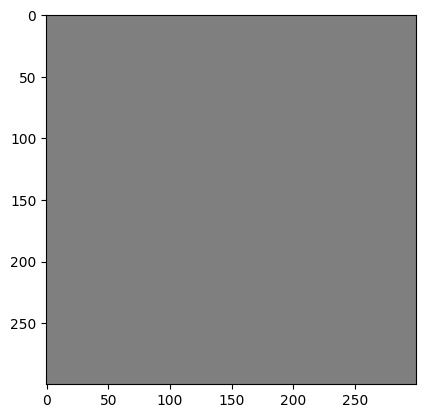

In [33]:
img = read_image(image_paths[0])
o_img, e_img = encode_image(image_paths[0])

out = model(prepareTensor(e_img).unsqueeze(0).to(device)).to("cpu")

out = out * 255
np.uint8(out.squeeze().permute(1, 2, 0).detach().numpy())

In [48]:
%matplotlib tk

class TrainingDashboard():
    def __init__(self):
        plt.style.use("seaborn-v0_8-dark")
        self.fig = plt.figure()
        self.oimg_ax = self.fig.add_axes((0, 0.5, 0.5, 0.5))
        self.timg_ax = self.fig.add_axes((0.5, 0.5, 0.5, 0.5))

        self.loss_ax = self.fig.add_axes((0, 0, 1, 0.5))

        self.oimg_ax.axis("off")
        self.timg_ax.axis("off")

        self.loss_ax.axis("off")

        
    
    def update(self):
        self.fig.canvas.flush_events()

    def loss_axis(self, epoch, loss):
        self.loss_ax.plot(epoch, loss, "ro--")

    def setorg_img(self, image, cmap=None):
        assert image is np.ndarray and image.dtype == np.uint8
        self.oimg_ax.imshow(image, cmap=cmap)


    def setrecon_img(self, image, cmap=None):
        assert image is np.ndarray and image.dtype == np.uint8
        self.timg_ax.imshow(image, cmap=cmap)


dash = TrainingDashboard()

import time
for i in range(0, 10):
    dash.loss_axis(i, 5)
    dash.update()
    plt.pause(1)
